### Library and Data Import

In [2]:
# Library import
from datetime import datetime
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from prophet import Prophet
from prophet.plot import plot_plotly
rcParams['figure.figsize'] = 10, 6

In [3]:
# Data import
df = pd.read_csv('Dataset/transactionbydate.csv', sep = ';')
df = df.rename(columns={'sum':'value'})
df = df.set_index('date')
df.head()

,value
date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30


### Data Overview and Preparation

In [3]:
# Data Overview
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
value,365.0,50.126027,16.704461,15.0,38.0,49.0,59.0,119.0


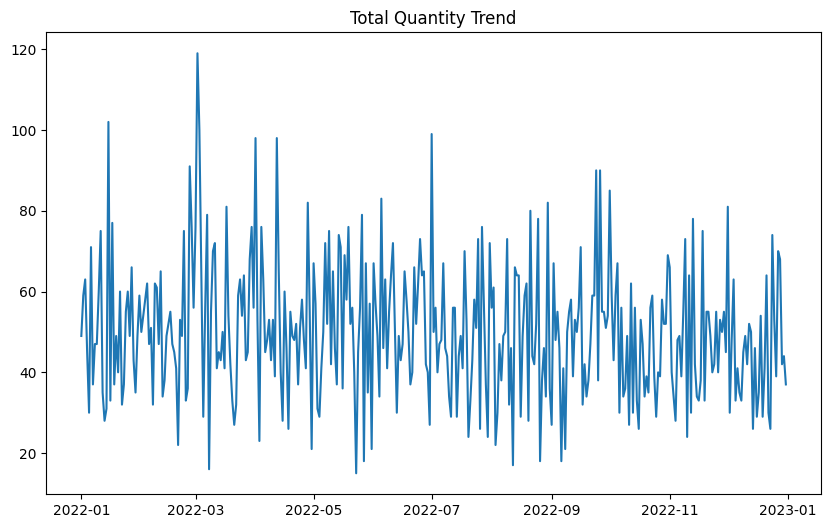

In [4]:
df.index = pd.to_datetime(df.index)
plt.plot(df.index, df['value'])
plt.title('Total Quantity Trend')
plt.show()

In [5]:
#Perform Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['value'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -19.448086
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


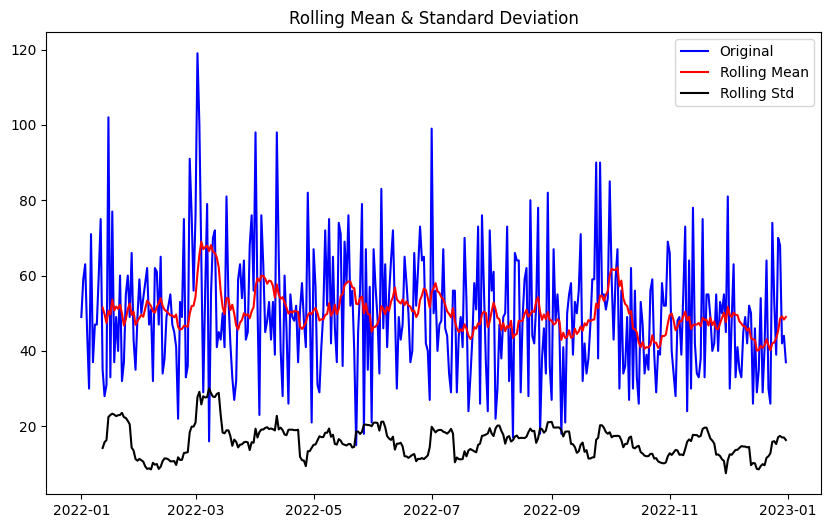

In [6]:
#Determine rolling statistics
movingAverage = df.rolling(window=12).mean()
movingSTD = df.rolling(window=12).std()
    
#Plot rolling statistics
orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
std = plt.plot(movingSTD, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

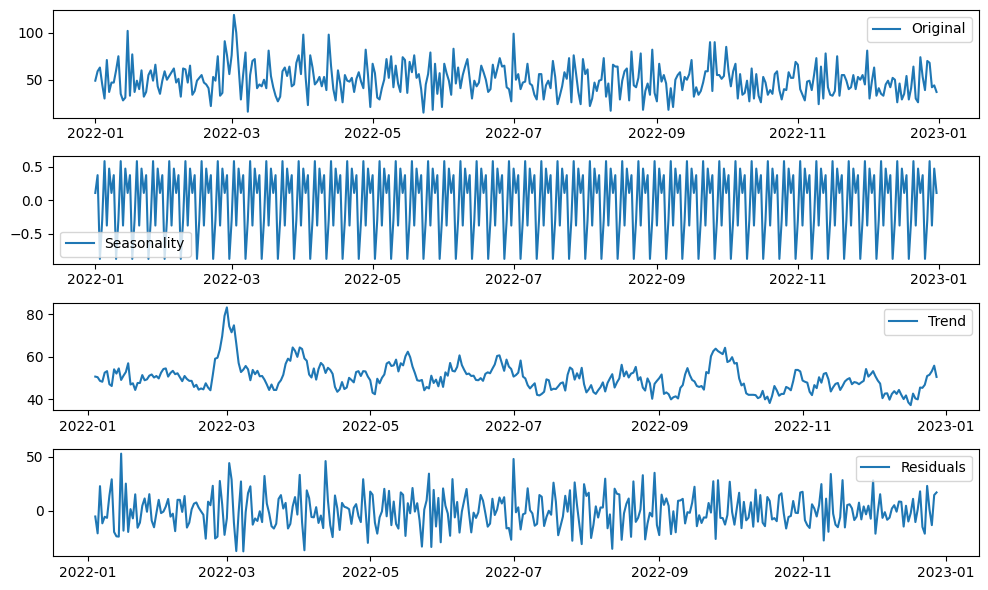

In [7]:
decomposition = seasonal_decompose(df) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)

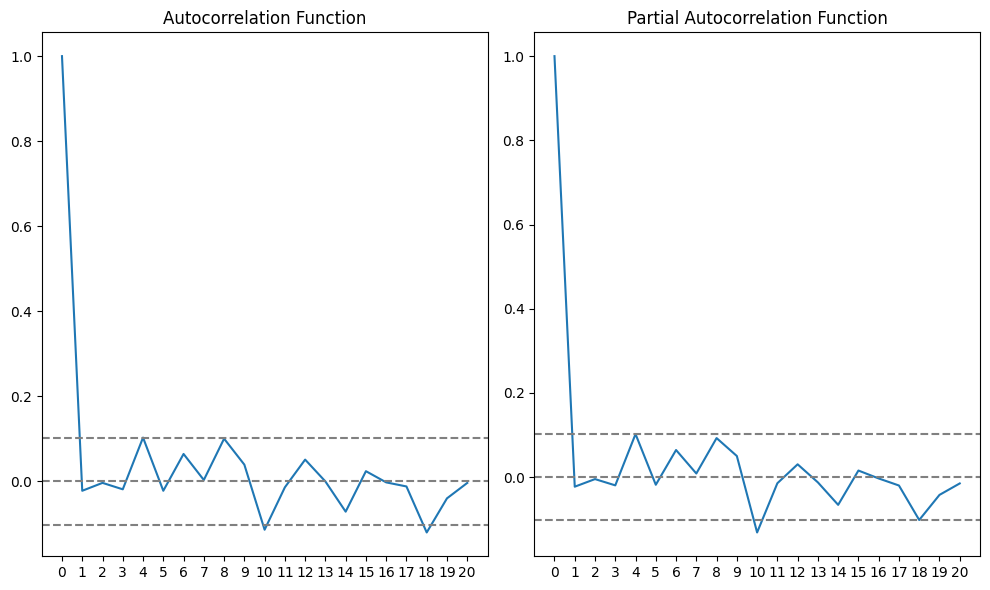

In [8]:
#ACF & PACF plots

lag_acf = acf(df, nlags=20)
lag_pacf = pacf(df, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.xticks(range(0, len(lag_acf)))     
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')     

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.xticks(range(0, len(lag_pacf)))
plt.axhline(y=-1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()  

In [9]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

train_data = df[1:round(len(df)*0.9)]
test_data = df[round(len(df)*0.9):]

p_values = range(0, 10)
d_values = range(0, 2)
q_values = range(0, 2)

best_model = None
best_mse = float('inf')

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            warnings.filterwarnings("ignore")
            try:
                model = ARIMA(train_data.value, order=order).fit()
                predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
                error = mean_squared_error(test_data, predictions)

                if error < best_mse:
                    best_mse = error
                    best_model = model

            except:
                continue

print("\nBest ARIMA Model:")
print(best_model.summary())


Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  327
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -1402.264
Date:                Thu, 27 Jul 2023   AIC                           2818.527
Time:                        19:14:01   BIC                           2845.036
Sample:                    01-02-2022   HQIC                          2829.106
                         - 11-24-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8902      0.057    -15.754      0.000      -1.001      -0.779
ar.L2         -0.7665      0.071    -10.823      0.000      -0.905      -0.628
ar.L3         -0.6905      0.072 

In [10]:
model = ARIMA(train_data.value, order=(6,1,0)).fit()
predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
error = mean_squared_error(test_data, predictions)
rmse = np.sqrt(error)
r2 = r2_score(test_data, np.array(predictions))
print('MSE : ', error)
print('RMSE : ', rmse)
print('R2 Score : ', r2)

MSE :  183.241322741212
RMSE :  13.53666586502053
R2 Score :  0.004463132951086801


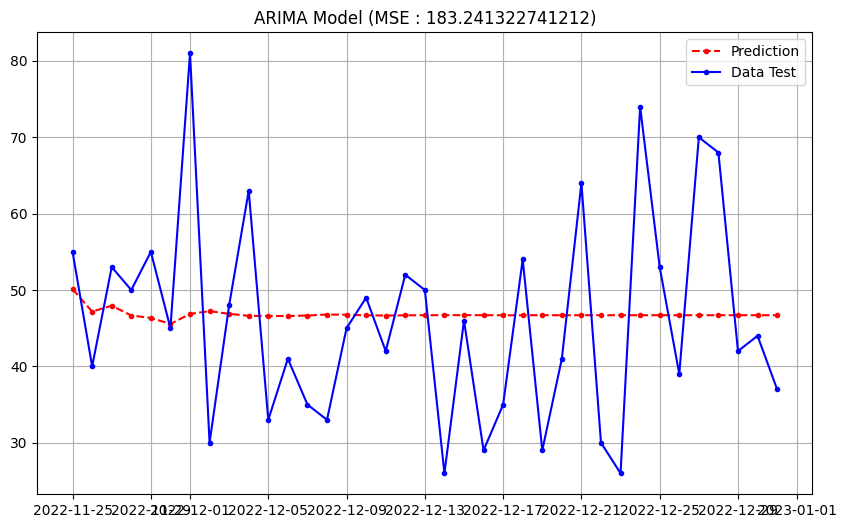

In [11]:
plt.figure(figsize = (10,6))
plt.grid(True)

plt.plot(predictions.index, predictions, color = 'red', marker = '.', linestyle = 'dashed', label = 'Prediction')
plt.plot(test_data.index, test_data, color = 'blue', marker = '.', label = 'Data Test')

plt.title('ARIMA Model (MSE : '  + error.astype(str) + ')')
plt.legend()
plt.show()

In [12]:
p_values = range(0, 15)
d_values = range(0, 2)
q_values = range(0, 2)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)

from itertools import product
best_model = None
best_mse = float('inf')

for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    order = (p, d, q)
    seasonal_order = (P, D, Q, 7)

    warnings.filterwarnings("ignore")
    try:
        model = ARIMA(train_data.value, order=order, seasonal_order=seasonal_order).fit()
        predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
        error = mean_squared_error(test_data, predictions)

        if error < best_mse:
            best_mse = error
            best_model = model

    except:
        continue

print("\nBest ARIMA Model:")
print(best_model.summary())



Best ARIMA Model:
                                    SARIMAX Results                                    
Dep. Variable:                           value   No. Observations:                  327
Model:             ARIMA(6, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1380.000
Date:                         Thu, 27 Jul 2023   AIC                           2780.001
Time:                                 19:21:22   BIC                           2817.869
Sample:                             01-02-2022   HQIC                          2795.112
                                  - 11-24-2022                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8889      0.050    -17.913      0.000      -0.986      -0.792
ar.L2         -0.8284      0.053    -15.

In [6]:
model_tuning = ARIMA(train_data.value, order=(6, 1, 1), seasonal_order=(1, 0, 1, 7)).fit()
predictions_tuning = model_tuning.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
error_tuning = mean_squared_error(test_data, predictions_tuning)
rmse_tuning = np.sqrt(error_tuning)
r2_tuning = r2_score(test_data, np.array(predictions_tuning))
print('MSE : ', error_tuning)
print('RMSE : ', rmse_tuning)
print('R2 Score : ', r2_tuning)

c:\Users\una\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\una\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\una\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



MSE :  182.60366442009428
RMSE :  13.513092333736726
R2 Score :  0.00792748453814529


c:\Users\una\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



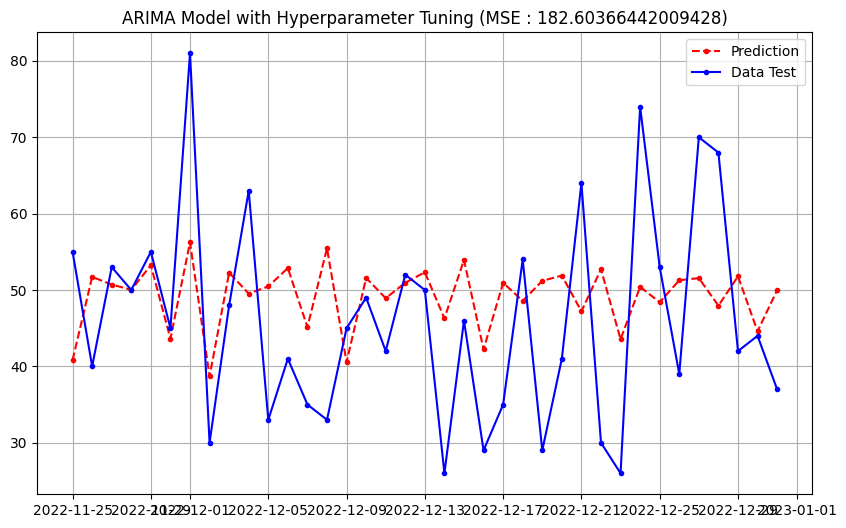

In [14]:
plt.figure(figsize = (10,6))
plt.grid(True)

plt.plot(predictions_tuning.index, predictions_tuning, color = 'red', marker = '.', linestyle = 'dashed', label = 'Prediction')
plt.plot(test_data.index, test_data, color = 'blue', marker = '.', label = 'Data Test')

plt.title('ARIMA Model with Hyperparameter Tuning (MSE : '  + error_tuning.astype(str) + ')')
plt.legend()
plt.show()

In [69]:
baseline_model = Prophet(changepoint_prior_scale = 0.1, seasonality_prior_scale = 0.0001, seasonality_mode = 'multiplicative')
train_data_prop = train_data.copy().reset_index().rename(columns = {'date':'ds', 'value':'y'})
baseline_model.fit(train_data_prop)
future = baseline_model.make_future_dataframe(periods=len(test_data))
forecast = baseline_model.predict(future)
forecast_prophet = forecast.iloc[len(train_data_prop):]
predictions_prophet = forecast_prophet['yhat']
error_prophet = mean_squared_error(test_data, predictions_prophet)
rmse_prophet = np.sqrt(error_prophet)
r2_prophet = r2_score(test_data, predictions_prophet)
print('MSE : ', error_prophet)
print('RMSE : ', rmse_prophet)
print('R2 Score : ', r2_prophet)

20:30:55 - cmdstanpy - INFO - Chain [1] start processing
20:30:56 - cmdstanpy - INFO - Chain [1] done processing


MSE :  183.97615953703175
RMSE :  13.563781166659677
R2 Score :  0.0004708177322330087


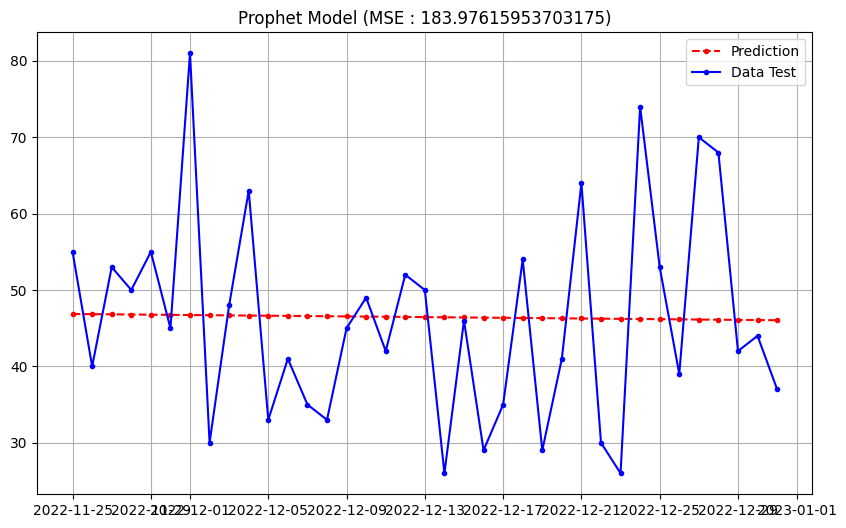

In [72]:
plt.figure(figsize = (10,6))
plt.grid(True)

plt.plot(test_data.index, predictions_prophet, color = 'red', marker = '.', linestyle = 'dashed', label = 'Prediction')
plt.plot(test_data.index, test_data, color = 'blue', marker = '.', label = 'Data Test')

plt.title('Prophet Model (MSE : '  + error_prophet.astype(str) + ')')
plt.legend()
plt.show()

In [9]:
future_prediction = model_tuning.predict(364,395)

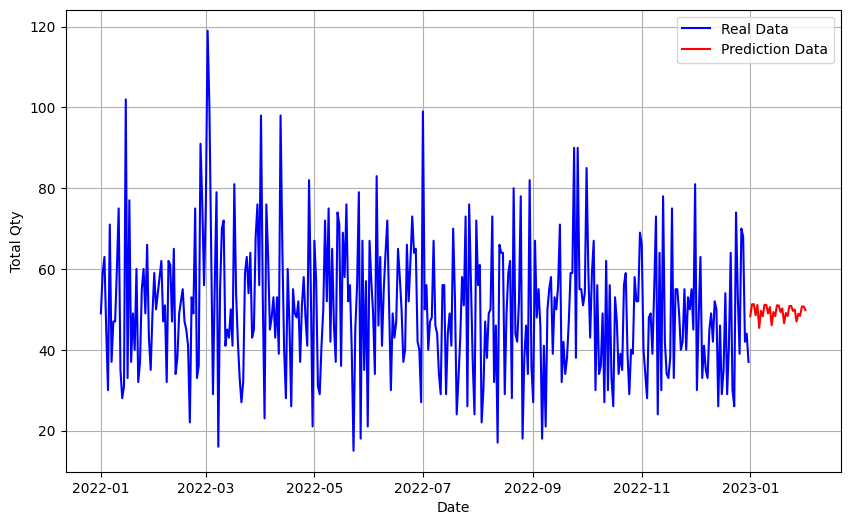

In [76]:
# Plot train and test data

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Total Qty')
plt.plot(df, 'blue', label = 'Real Data')
plt.plot(future_prediction, 'Red', label = 'Prediction Data')
plt.legend()

In [14]:
future_prediction.values

array([48.31384554, 51.24121329, 51.30713845, 48.5303003 , 51.10248644,
       45.41105699, 49.61571392, 48.29674284, 51.1400145 , 51.11086364,
       48.98829481, 50.5977562 , 46.05954034, 49.32387662, 48.31476421,
       51.002294  , 50.95599659, 49.34224074, 50.23509834, 46.57753492,
       49.0892099 , 48.35022612, 50.84715478, 50.83111635, 49.61233497,
       49.98059436, 46.99514376, 48.90325567, 48.39213199, 50.68676623,
       50.7277252 , 49.81553778])

In [20]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the real data trace
fig.add_trace(go.Scatter(x=df.index, y=df['value'], mode='lines', name='Real Data', line=dict(color='blue')))

# Add the prediction data trace
fig.add_trace(go.Scatter(x=future_prediction.index, y=future_prediction.values, mode='lines', name='Prediction Data', line=dict(color='red')))

# Update the layout
fig.update_layout(title='Prediction with ARIMA',
                  xaxis_title='Date',
                  yaxis_title='Total Qty',
                  showlegend=True)

# Show the plot
fig.show()